In [4]:
import os
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, RFE

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import f1_score

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from hpsklearn import HyperoptEstimator, any_classifier, any_preprocessing
from hyperopt import tpe

import neptune.new as neptune


# **Neptune**

In [5]:
NEPTUNE_API_TOKEN = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1Yjc4NDczMC0zNzc1LTQ0ZjEtYTYwYS0wMjNhNjNhMDNiOGEifQ=="
run = neptune.init(project='marcelmilosz/projekt-ml', api_token=NEPTUNE_API_TOKEN)

params = {
    "optimizer": "Marcel"
}
run["parameters"] = params


def send_data_neptune(data, plot_name):
    """ Sending array with data to neptune"""

    for epoch in range(0, len(data)):
      run[plot_name].log(data[epoch])

def single_record(record, record_name):
    """ Sending single record to neptune """

    run[record_name] = record

def stop_run():
    """ Stoping run at the end of the program """

    run.stop()

Info (NVML): Driver Not Loaded. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/marcelmilosz/projekt-ml/e/PROJ-93
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [6]:
os.environ["OMP_NUM_THREADS"] = "1"

In [7]:
seed = np.random.seed(147)

In [9]:
def data_load() -> list:
    """
    Loading csv files to DataFrames
    :return: None
    """
    
    train_data_out = pd.read_csv("project_data/train_data.csv", header=None)
    test_data_out = pd.read_csv("project_data/test_data.csv", header=None)
    train_labels_out = pd.read_csv("project_data/train_labels.csv", header=None)

    # Save to neptune train labels
    a = train_labels.values
    tmp = []
    for i in range(0, len(a)):
      tmp.append(int(a[i]))

    send_data_neptune(tmp, "train_labels")

    return [train_data_out, test_data_out, train_labels_out]

In [ ]:
train_data, test_data, train_labels = data_load()

In [ ]:
train_labels_ravel = train_labels.values.ravel()

# Preprocessing

### problem: multidimensional dataset, 
### solution: dimensional reduction (Correlation Heatmap, Univariate Selection/ PCA - Principal Component Analysis/ RFE - Recursive Feature Elimination)

In [ ]:
def pipe_std_minmax(x_1: pd.DataFrame, x_2: pd.DataFrame) -> list:
    """
    Data standardization and normalization
    :param x_1: pd.DataFrame: train data
    :param x_2: pd.DataFrame: test data
    :return: list: of np.array-s of standardized train and test data
    """
    
    pipe = Pipeline([
    ("std", StandardScaler()),
    ("minmax", MinMaxScaler())
    ])
    
    train_std_minmax_out = pipe.fit_transform(x_1)
    test_std_minmax_out = pipe.fit_transform(x_2)
    
    return [train_std_minmax_out, test_std_minmax_out]

In [ ]:
train_std_minmax, test_std_minmax = pipe_std_minmax(train_data, test_data)

In [ ]:
k=int(len(train_data.columns)/3)

In [ ]:
def univariate_select(x_1: np.array, x_2: np.array, y_1: np.array, n_of_kbest: int) -> list:
    """
    Univariate Selection
    :param x_1: pd.DataFrame: standardized train data
    :param x_2: pd.DataFrame: standardized test data
    :param y_1: np.array: ravel of train labels
    :param n_of_kbest: int: specify number of k best in SelectKBest
    :return: list: of np.array with univariate test and train data
    """
    
    print(f"Shape before: {x_1.shape}\n")
    
    test = SelectKBest(score_func=f_classif, k=n_of_kbest)
    fit = test.fit(x_1, y_1)
    features_1 = fit.transform(x_1)
    features_2 = fit.transform(x_2)
    
    scores = fit.scores_
    score_df = pd.DataFrame(scores, columns=["Scores"])
    print(f"Min score: {min(score_df.Scores)}, max score: {max(score_df.Scores)}, mean score: {np.mean(score_df.Scores)}\n")    
    print(f"Shape after: {features_1.shape}\n")
    
    score_df.drop(score_df[score_df.Scores < 1].index, inplace=True)
    l = len(score_df)

    ## Save to Neptune
    single_record(min(score_df.Scores), 'univariate_select_min_score')
    single_record(max(score_df.Scores), 'univariate_select_max_score')
    single_record(np.mean(score_df.Scores), 'univariate_select_mean_score')
    
    if l != n_of_kbest:
        return univariate_select(train_std_minmax, test_std_minmax, train_labels_ravel, l)
    else:
        return [features_1, features_2]

In [ ]:
univariate_train, univariate_test = univariate_select(train_std_minmax, test_std_minmax, train_labels_ravel, k)

Shape before: (3750, 10000)

Min score: 1.7567042700994732e-09, max score: 17.321255892491074, mean score: 1.000380011727586

Shape after: (3750, 3333)

Shape before: (3750, 10000)

Min score: 1.7567042700994732e-09, max score: 17.321255892491074, mean score: 1.000380011727586

Shape after: (3750, 3177)



In [ ]:
def pca_select(x_1: np.array, x_2: np.array) -> list:
    """
    Principal Component Analysis
    :param x_1: np.array: univariate train data
    :param x_2: np.array: univariate test data
    :return: list: of np.array-s reshaped by PCA test and train data
    """
    
    print(f"Shape before: {x_1.shape}\n")
    
    pca = PCA(n_components=100, random_state=seed)
    fit = pca.fit(x_1)
    features_1 = fit.transform(x_1)
    features_2 = fit.transform(x_2)
    
    print(f"Explained Variance: \n{fit.explained_variance_ratio_}\n")
    print(f"Shape after: {features_1.shape}")

    # Send to Neptune
    send_data_neptune(fit.explained_variance_ratio_, "explained_variance_ration")
    
    return [features_1, features_2]

In [ ]:
pca_train, pca_test = pca_select(univariate_train, univariate_test)

Shape before: (3750, 3177)

Explained Variance: 
[0.00119644 0.0011572  0.00114932 0.00114815 0.00114109 0.00113676
 0.0011336  0.00113102 0.00112559 0.00112421 0.00111666 0.00111646
 0.00111411 0.00110989 0.00110611 0.00110364 0.00109874 0.00109676
 0.00109307 0.00109102 0.0010901  0.00108277 0.00108163 0.0010793
 0.00107742 0.00107588 0.00107237 0.00106929 0.00106777 0.00106614
 0.00106504 0.00106352 0.0010601  0.00105923 0.00105696 0.00105041
 0.00104802 0.00104656 0.00104519 0.00104268 0.00104112 0.00104055
 0.00103838 0.00103691 0.00103446 0.00102977 0.0010284  0.00102667
 0.00102507 0.00102168 0.00101906 0.00101652 0.00101368 0.00101249
 0.00101097 0.00101016 0.00100867 0.00100588 0.00100427 0.00100261
 0.00100051 0.00099868 0.00099487 0.00099332 0.00099223 0.00098997
 0.00098815 0.00098489 0.00098367 0.00098203 0.00097907 0.00097823
 0.00097593 0.00097449 0.00096828 0.00096637 0.00096389 0.00096264
 0.00096064 0.00095803 0.00095728 0.00095593 0.00095393 0.00095246
 0.00095021 0.

In [ ]:
def rfe_select(x_1: np.array, x_2: np.array, y_1: np.array) -> list:
    """
    Recursive Feature Elimination
    :param x_1: np.array: reshaped train data
    :param x_2: np.array: reshaped train data
    :param y_1: np.array: ravel of train labels
    :return: list: of np.array-s reshaped by RFE test and train data
    """
    
    print(f"Shape before: {x_1.shape}\n")
    
    svc = SVC(kernel="linear", C=1, random_state=seed)
    rfe = RFE(estimator=svc, n_features_to_select=5)
    fit = rfe.fit(x_1, y_1)
    features_1 = fit.transform(x_1)
    features_2 = fit.transform(x_2)
    
    print(f"Feature Ranking: \n{fit.ranking_}\n")
    print(f"Shape after: {features_1.shape}\n")

    # Send to Neptune
    send_data_neptune(fit.ranking_, "fit-ranking")
    
    return [features_1, features_2]

In [ ]:
rfe_train, rfe_test = rfe_select(pca_train, pca_test, train_labels_ravel)

Shape before: (3750, 100)

Feature Ranking: 
[ 1 12  1 79 78  1  2  4 83 72  9 47  7 76 63 82 46  1  5 66 15 23 96 30
 48  3 61 77 55 13 85 42 81 18 32 53 27 68 25 57 69 20 28 24 11 80 10 40
 59 75 43 70 67 87 93 26 52 31 21 90 39 62 14  8 35 34 88 95 29 58 56 84
 54  6 71 22 86 33 49 74 65 17 37 45 41 89 50 60 44  1 36 91 19 51 92 38
 64 16 94 73]

Shape after: (3750, 5)



### problem: unbalanced dataset, 
### solution: Random Oversampling/SMOTE

In [11]:
from imblearn.pipeline import Pipeline

In [12]:
def random_sampling(x_1: np.array, y_1: np.array) -> list:
    """
    Random Oversampling/Undersampling
    :param x_1: np.array: reshaped train data
    :param y_1: np.array: ravel of train labels
    :return: list: of np.array-s after over and undersampling
    """
    
    over = RandomOverSampler(sampling_strategy=0.2)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)

    x_resampled_out, y_resampled_out = pipeline.fit_resample(x_1, y_1)

    ## Save X and y resampled to neptune

    tmp_X = []
    for i in range(0, len(X_resampled)):
      for j in range(0, len(X_resampled[i])):
        tmp_X.append(X_resampled[i][j])
    
    send_data_neptune(tmp_X, "X-resampled")
    send_data_neptune(y_resampled, "y-resampled")
    
    return [x_resampled_out, y_resampled_out]

In [13]:
x_resampled, y_resampled = random_sampling(rfe_train, train_labels_ravel)

NameError: ignored

In [ ]:
def save_data(train_x: np.array, test_x: np.array, train_y: np.array) -> None:
    """
    Save to npy file
    :param train_x: np.array: train data after over and undersampling
    :param test_x: np.array: of reshaped test data by RFE
    :param train_y: np.array: train values after over and undersampling
    :return: None
    """
    
    np.save('project_data/processed_train_X.npy', train_x)
    np.save('project_data/processed_test_X.npy', test_x)
    np.save('project_data/processed_train_y.npy', train_y)
    
    print("Saving has been completed.")

In [ ]:
save_data(x_resampled, rfe_test, y_resampled)

# EDA part 2

In [ ]:
df = pd.DataFrame(x_resampled, index=None, columns=None)

In [ ]:
def correlation_heatmap(data: pd.DataFrame) -> plt:
    """
    Correlation heatmap for preprocessed train data
    :param data: pd.DataFrame: of train data after over and undersampling
    :return: plt: correlation heatmap
    """
    
    plt.figure(figsize=(16.9, 8))
    heat_mask = np.triu(np.ones_like(data.corr(), dtype=bool))
    sns.heatmap(data.corr(), mask=heat_mask, vmin=-1, vmax=1, annot=True)
    plt.title("Correlation heatmap for preprocessed train data")
    
    return plt.show()

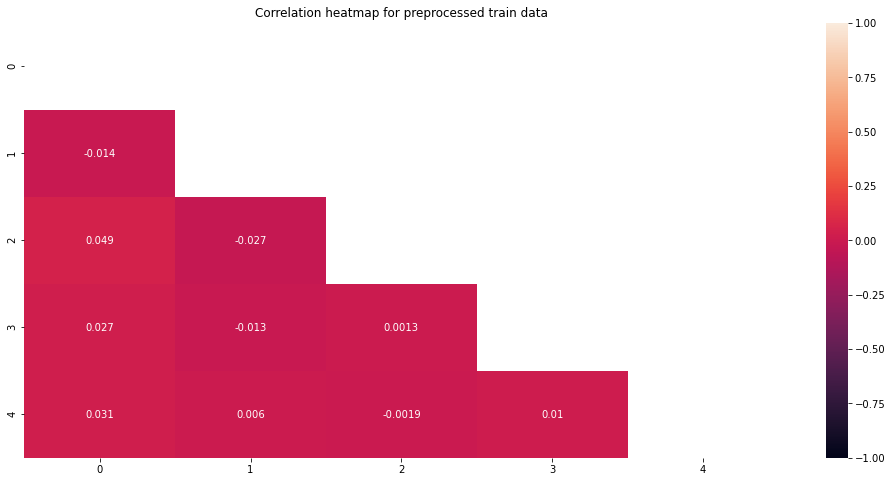

In [ ]:
correlation_heatmap(df)

In [ ]:
def pair_plot(data: pd.DataFrame) -> plt:
    """
    Pair plot for preprocessed train data
    :param data: pd.DataFrame: of train data after over and undersampling
    :return: plt: pair plot for preprocessed train data
    """

    plt.figure(figsize=(14,8))    
    g = sns.pairplot(data, corner=True)
    g.fig.suptitle("Pair plot for preprocessed train data")

    return plt.show()

<Figure size 1008x576 with 0 Axes>

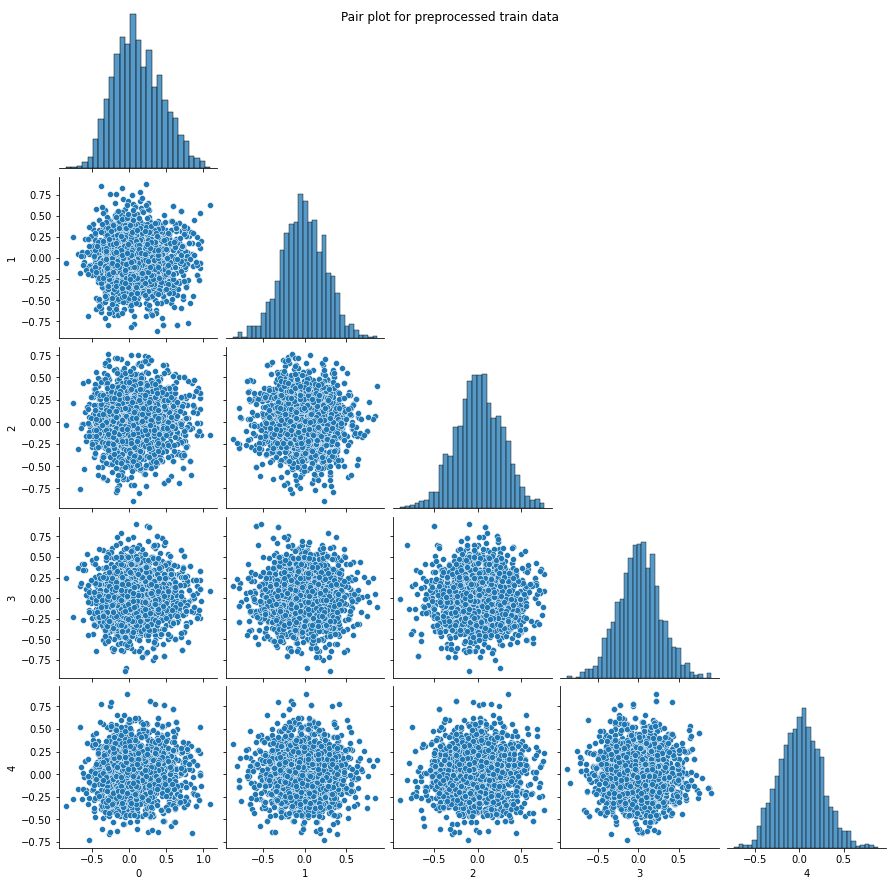

In [ ]:
pair_plot(df)

In [ ]:
def box_plot(data: pd.DataFrame) -> plt:
    """
    Box plot for preprocessed train data
    :param data: pd.DataFrame: of train data after over and undersampling
    :return: plt: box plot
    """
    
    plt.figure(figsize=(15.2, 8))
    sns.boxplot(data=data)
    plt.title("Box plot for preprocessed train data")
    
    return plt.show()

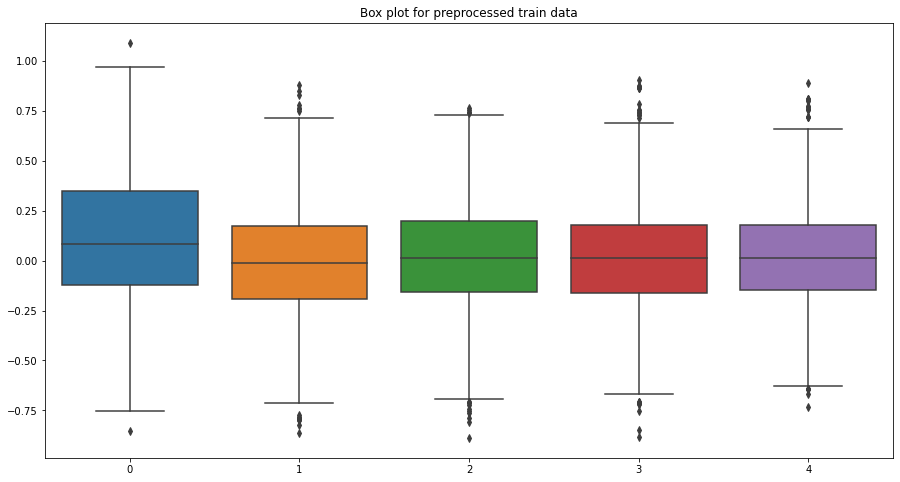

In [ ]:
box_plot(df)

In [ ]:
def scatter_plot(x_1: np.array, y_1: np.array) -> plt:
    """
    Summarize class distribution and plot scatter for preprocessed train data
    :param x_1: np.array: train data after over and undersampling
    :param y_1: np.array: train values after over and undersampling
    :return: plt: scatter plot for preprocessed data
    """

    counter = Counter(y_1)

    plt.figure(figsize=(15.1, 13))
    for label, _ in counter.items():
        row_ix = np.where(y_1 == label)[0]
        plt.scatter(x_1[row_ix, 0], x_1[row_ix, 1], label=str(label),
                    s=100, marker="o", alpha=0.5, edgecolor="black")
    plt.title(f"Scatter plot for preprocessed data with {counter}")
    plt.legend()
    
    return plt.show()

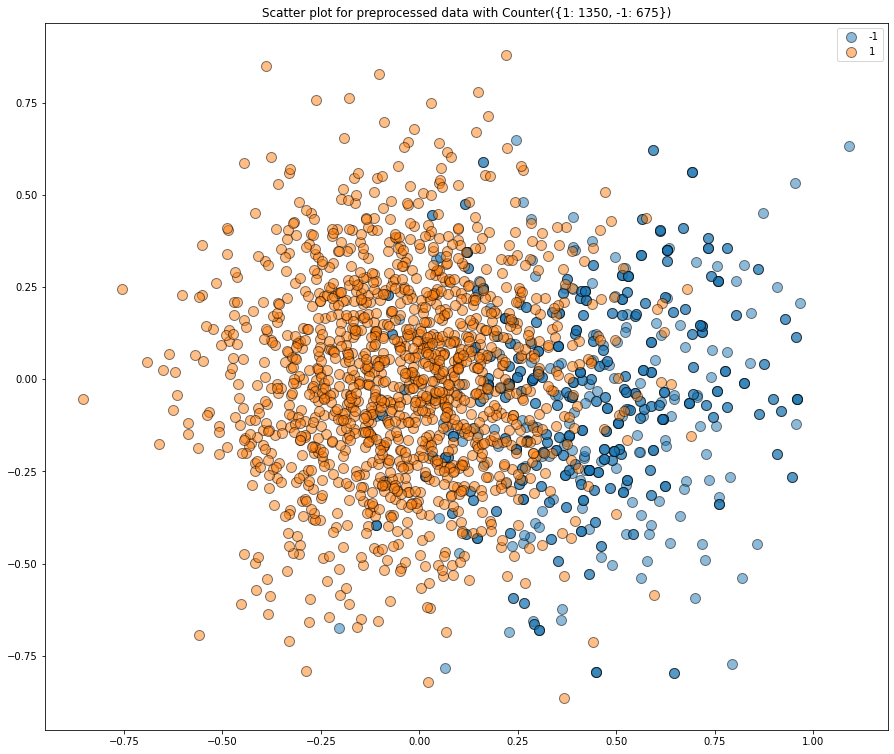

In [ ]:
scatter_plot(x_resampled, y_resampled)

# Basic Models

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.25, random_state=seed)

In [ ]:
def pipe_basic_model(x_1: np.array, x_2: np.array, y_1: np.array, y_2: np.array) -> None:
    """
    Base line model picking with repeated skf, GridSearchCV in pipeline
    :param x_1: np.array: train of data after over and undersampling
    :param x_2: np.array: test of data after over and undersampling
    :param y_1: np.array: train of values after over and undersampling
    :param y_2: np.array: test of values after over and undersampling
    :return: None
    """
    
    pipe = Pipeline([("classifier", SVC(kernel="linear", C=1, random_state=seed))])
    
    search_space = [
        {"classifier": [SVC(random_state=seed)]},
        {"classifier": [LinearSVC(random_state=seed)]},
        {"classifier": [LogisticRegression(random_state=seed)]},
        {"classifier": [KNeighborsClassifier()]},
        {"classifier": [MLPClassifier(random_state=seed)]},
        {"classifier": [AdaBoostClassifier(random_state=seed)]},
        {"classifier": [GradientBoostingClassifier(random_state=seed)]},
        {"classifier": [RandomForestClassifier(random_state=seed)]},
        {"classifier": [ExtraTreesClassifier(random_state=seed)]},
        {"classifier": [AdaBoostClassifier(random_state=seed)]},
        {"classifier": [GaussianNB()]}
    ]
    
    rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)
    gridsearch = GridSearchCV(pipe, search_space, cv=rskf, verbose=1, n_jobs=-1)
    best_model = gridsearch.fit(x_1, y_1)
    y_pred = best_model.predict(x_2)
    
    print(f"\nBest model: {best_model.best_estimator_.get_params()['classifier']}")
    print("\nMicro-averaged F1 score on test set: "
          "%0.3f" % f1_score(y_2, y_pred, average='micro'))
    
    single_record(f1_score(y_2, y_pred, average='micro'), "f1-score")

In [ ]:
pipe_basic_model(X_train, X_test, y_train, y_test)

Fitting 50 folds for each of 11 candidates, totalling 550 fits

Best model: ExtraTreesClassifier()

Micro-averaged F1 score on test set: 0.907


In [ ]:
def hyperopt_model(x_1: np.array, x_2: np.array, y_1: np.array, y_2: np.array) -> None:
    """
    Hyperopt model picking
    :param x_1: np.array: train of data after over and undersampling
    :param x_2: np.array: test of data after over and undersampling
    :param y_1: np.array: train of values after over and undersampling
    :param y_2: np.array: test of values after over and undersampling
    :return: None
    """

    model = HyperoptEstimator(
        classifier=any_classifier("cla"),
        preprocessing=any_preprocessing("pre"),
        algo=tpe.suggest,
        max_evals=10,
        trial_timeout=30
    )
    
    model.fit(x_1, y_1)
    y_pred = model.predict(x_2)
    
    print(f"\nBest model: {model.best_model()}")
    print("\nMicro-averaged F1 score on test set: "
          "%0.3f" % f1_score(y_2, y_pred, average='micro'))
    
    send_data_neptune(y_pred, "y_pred")
    single_record(f1_score(y_2, y_pred, average='micro'), "Micro-averaged F1 Score")

In [ ]:
hyperopt_model(X_train, X_test, y_train, y_test)

100%|████████████████████████████| 10/10 [00:01<00:00,  1.29s/trial, best loss: 0.11842105263157898]

Best model: {'learner': SVC(C=56.7140159315241, cache_size=512, degree=1, gamma='auto', kernel='linear',
    max_iter=40692963.0, random_state=4, tol=0.00010374472618808929), 'preprocs': (MinMaxScaler(feature_range=(0.0, 1.0)),), 'ex_preprocs': ()}

Micro-averaged F1 score on test set: 0.872


In [ ]:
stop_run()  # Stop Neptune